<a href="https://colab.research.google.com/github/Diogc8/Samsung/blob/main/cnn_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNNs and Visual Search: Exercises

In [1]:
import numpy as np
import torch
import urllib
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal
import torchvision.models as models
import torchvision.transforms as transforms
import json
import requests
import os
import glob
from pathlib import Path

### Convolutional Neural Networks

Load an image

Image shape: (427, 640, 3)


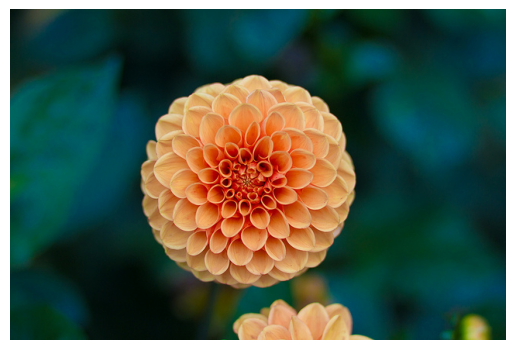

In [2]:
one_image = load_sample_image("flower.jpg")
print('Image shape: {}'.format(one_image.shape))
#Images are 3D arrays!

#Displaying the image
plt.imshow(one_image)
plt.axis('off')  # Turn off axis
plt.show()

Showing you the pretty colors :)

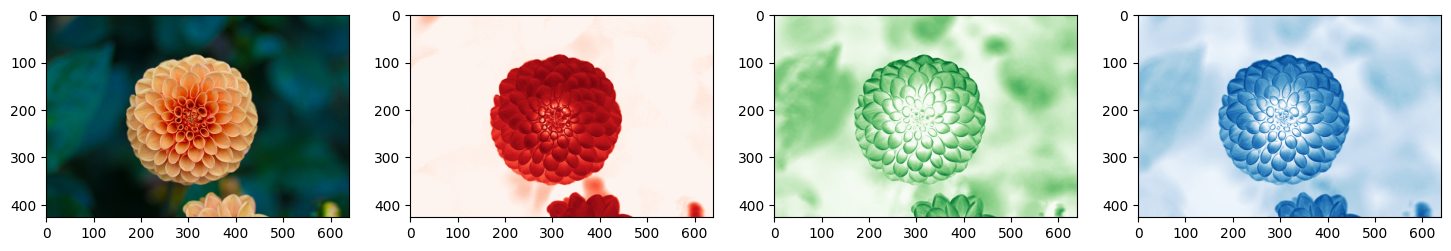

In [9]:
plt.figure(figsize=(18, 12))

plt.subplot(1,4,1)
plt.imshow(one_image)

plt.subplot(1,4,2)
red = one_image[:,:,0]
plt.imshow(red, cmap = 'Reds') # cmap = 'Reds'

plt.subplot(1,4,3)
blue = one_image[:,:,1]
plt.imshow(green, cmap = 'Greens') # cmap = 'Greens'

plt.subplot(1,4,4)
green = one_image[:,:,2]
plt.imshow(blue, cmap = 'Blues') # cmap = 'Blues'

#### Image Convolutions: An example!

In this case, we're doing **edge detection**! We are applying a horizontal_kernel and a vertical_kernel to each color channel (RGB) of the image in order to extract its **edges** and then applying these edges to the original photo itself!

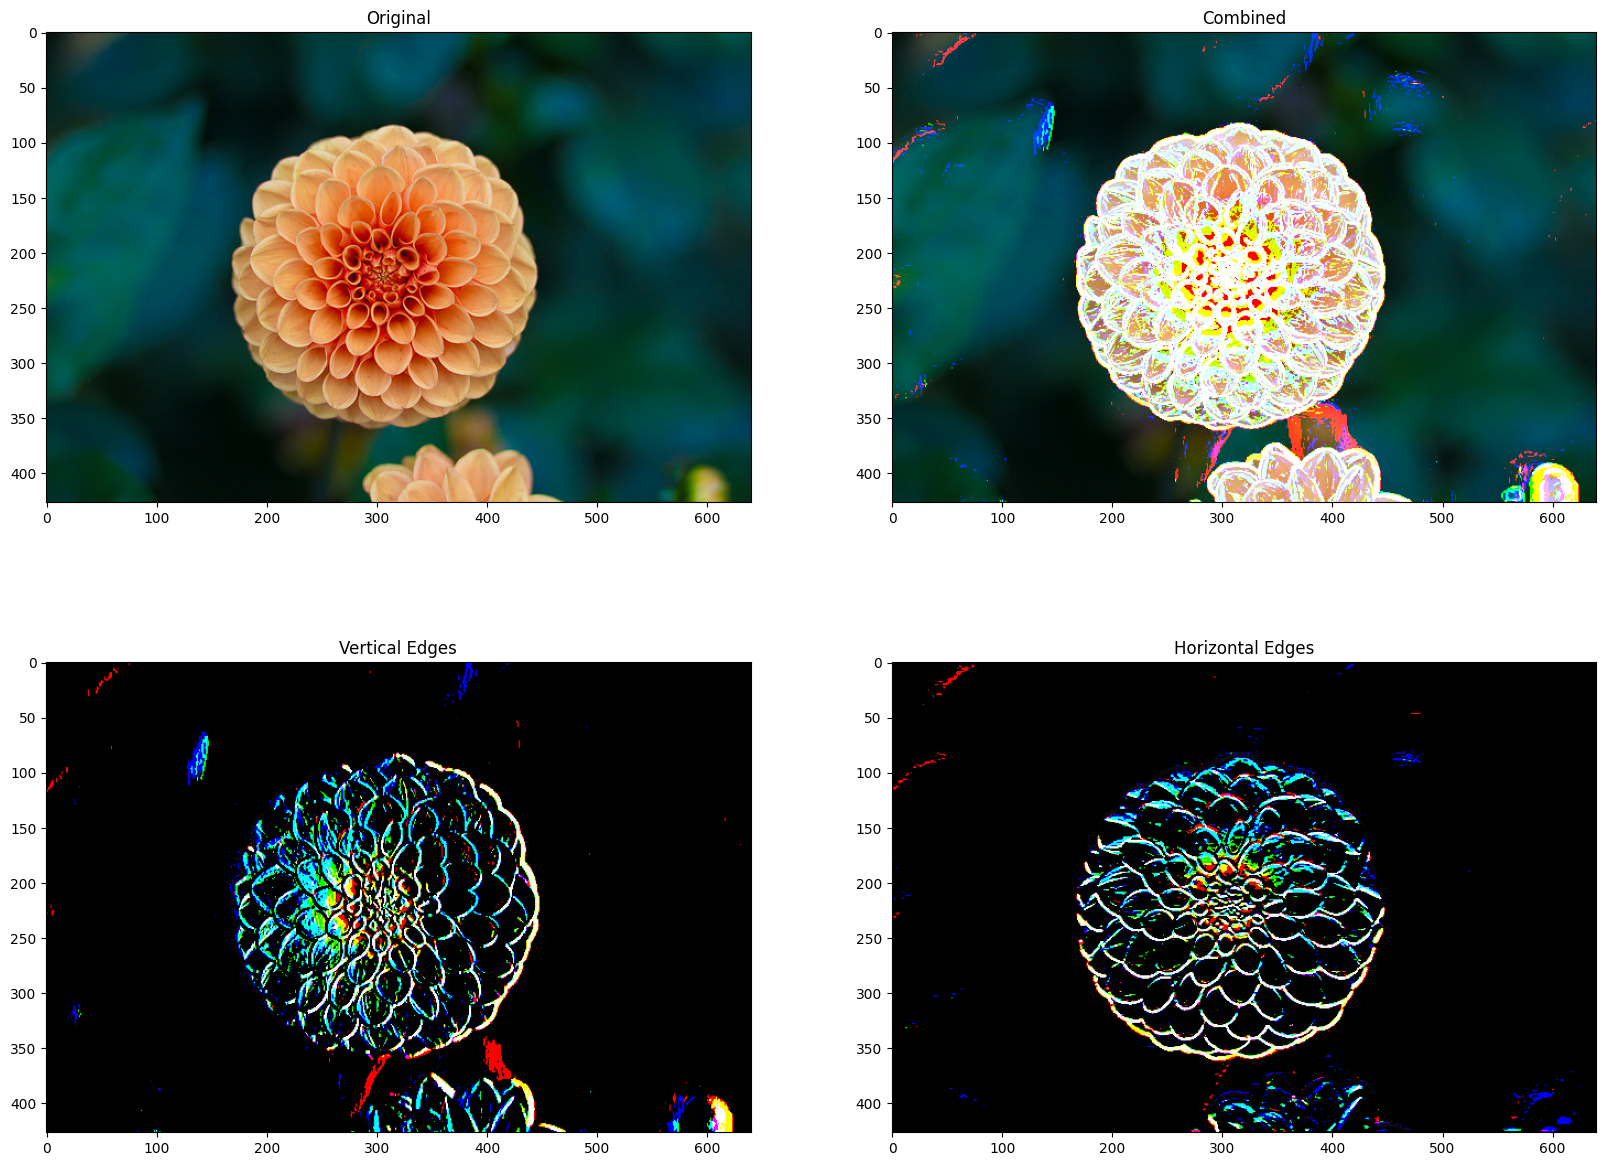

In [10]:
filtered_horizontal = one_image.copy()
horizontal_kernel = np.array([[ -10, -10, -10],
                              [ 0,     0,    0],
                              [ +10, +10, +10]])
filtered_horizontal[:,:,0] = signal.convolve2d(filtered_horizontal[:,:,0], horizontal_kernel, boundary='symm', mode='same')/255
filtered_horizontal[:,:,1] = signal.convolve2d(filtered_horizontal[:,:,1], horizontal_kernel, boundary='symm', mode='same')/255
filtered_horizontal[:,:,2] = signal.convolve2d(filtered_horizontal[:,:,2], horizontal_kernel, boundary='symm', mode='same')/255

filtered_vertical = one_image.copy()
verticals_kernel = np.array([[ -10, 0, +10],
                             [ -10, 0, +10],
                             [ -10, 0, +10]])
filtered_vertical[:,:,0] = signal.convolve2d(filtered_vertical[:,:,0], verticals_kernel, boundary='symm', mode='same')/255
filtered_vertical[:,:,1] = signal.convolve2d(filtered_vertical[:,:,1], verticals_kernel, boundary='symm', mode='same')/255
filtered_vertical[:,:,2] = signal.convolve2d(filtered_vertical[:,:,2], verticals_kernel, boundary='symm', mode='same')/255

residual = (one_image+filtered_horizontal+filtered_vertical)/255

plt.figure(figsize=(20, 15))
plt.subplot(2,2,1)
plt.imshow(one_image)
plt.subplot(2,2,3)
plt.imshow(filtered_vertical)
plt.subplot(2,2,4)
plt.imshow(filtered_horizontal)
plt.subplot(2,2,2)
plt.imshow(residual)

Now, let's make this tougher...

#### Exercise 1: Implementing a Convolution Step-by-Step

Let's try to do the same thing but this time, without the built-in convolution functions. Fill in the TODOs!

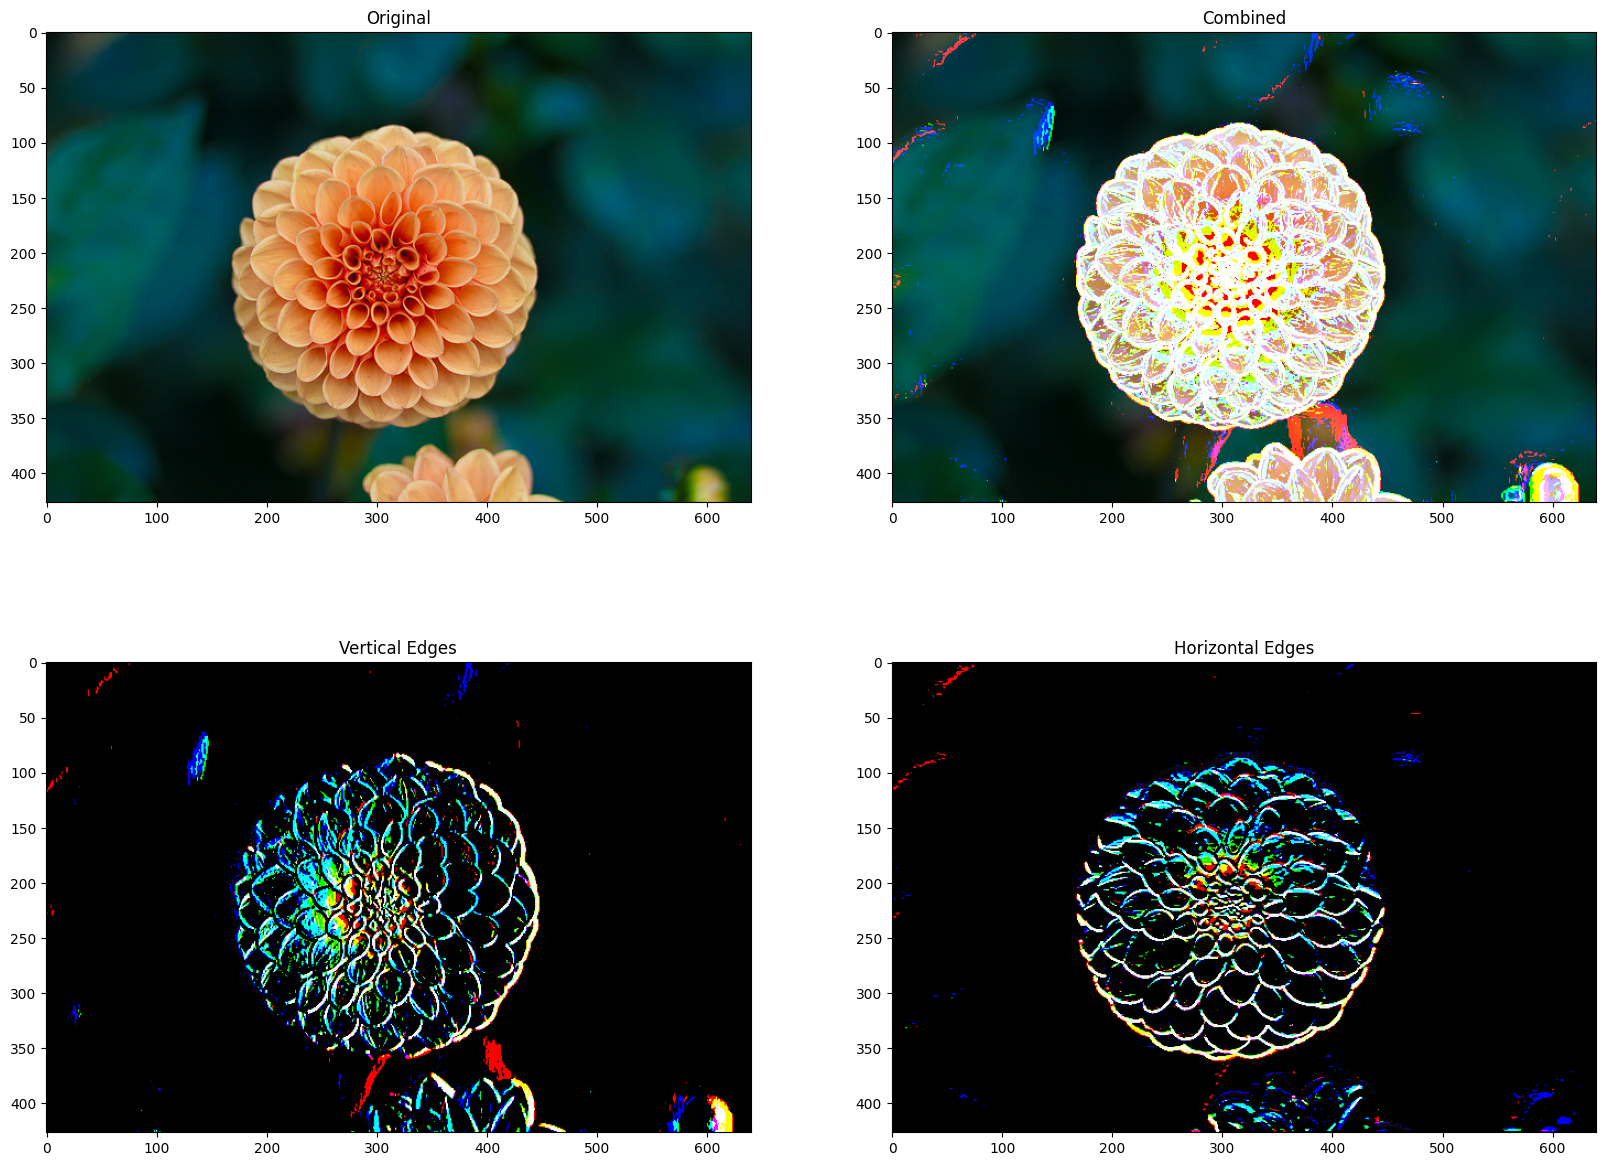

In [11]:
def apply_convolution(image_channel, kernel):
    """
    TODO: Implement the 2D convolution operation

    Args:
        image_channel: A padded 2D numpy array (single channel)
        kernel: The 3x3 kernel to apply

    Returns:
        The convolved image channel

    Hint:
    1. For each pixel position (i,j) in the output:
       - Take a 3x3 region around that position from the input
       - Multiply it element-wise with the kernel
       - Sum up the results to get the output pixel value
    """
    height, width = image_channel.shape
    output = np.zeros((height-2, width-2))

    # Your code here:
    # 1. Loop over each pixel position (excluding border)
    for i in range(height-2):
        for j in range(width-2):
            # 2. Get the 3x3 region centered at that pixel
            region = image_channel[i:i+3, j:j+3]

            # 3. Multiply with kernel and sum
            output[i, j] = np.sum(region * kernel)

    return output

def pad_image(image):
    #already assing symmetric padding to the image
    return np.pad(image, ((1,1), (1,1)), mode='symmetric')

def process_image(image, kernel):
    #function to apply your beautiful convolution
    output = np.zeros_like(image)

    for channel in range(3):
        padded_channel = pad_image(image[:,:,channel])
        #applying the convolution and normalizing!
        output[:,:,channel] = apply_convolution(padded_channel, kernel) / 255.0

    return output

#Test your code!
if __name__ == "__main__":

    horizontal_kernel = np.array([[-10, -10, -10],
                                [0, 0, 0],
                                [10, 10, 10]])

    vertical_kernel = np.array([[-10, 0, 10],
                              [-10, 0, 10],
                              [-10, 0, 10]])

    filtered_h = process_image(one_image, horizontal_kernel)
    filtered_v = process_image(one_image, vertical_kernel)

    result = (one_image/255.0 + filtered_h + filtered_v)

    plt.figure(figsize=(20, 15))
    plt.subplot(2,2,1)
    plt.imshow(one_image)
    plt.title('Original')
    plt.subplot(2,2,3)
    plt.imshow(filtered_v)
    plt.title('Vertical Edges')
    plt.subplot(2,2,4)
    plt.imshow(filtered_h)
    plt.title('Horizontal Edges')
    plt.subplot(2,2,2)
    plt.imshow(result)
    plt.title('Combined')
    plt.show()

Now let's take it a step further... Let's add stride! Don't forget that stride determines how many pixels we skip when moving the kernel!

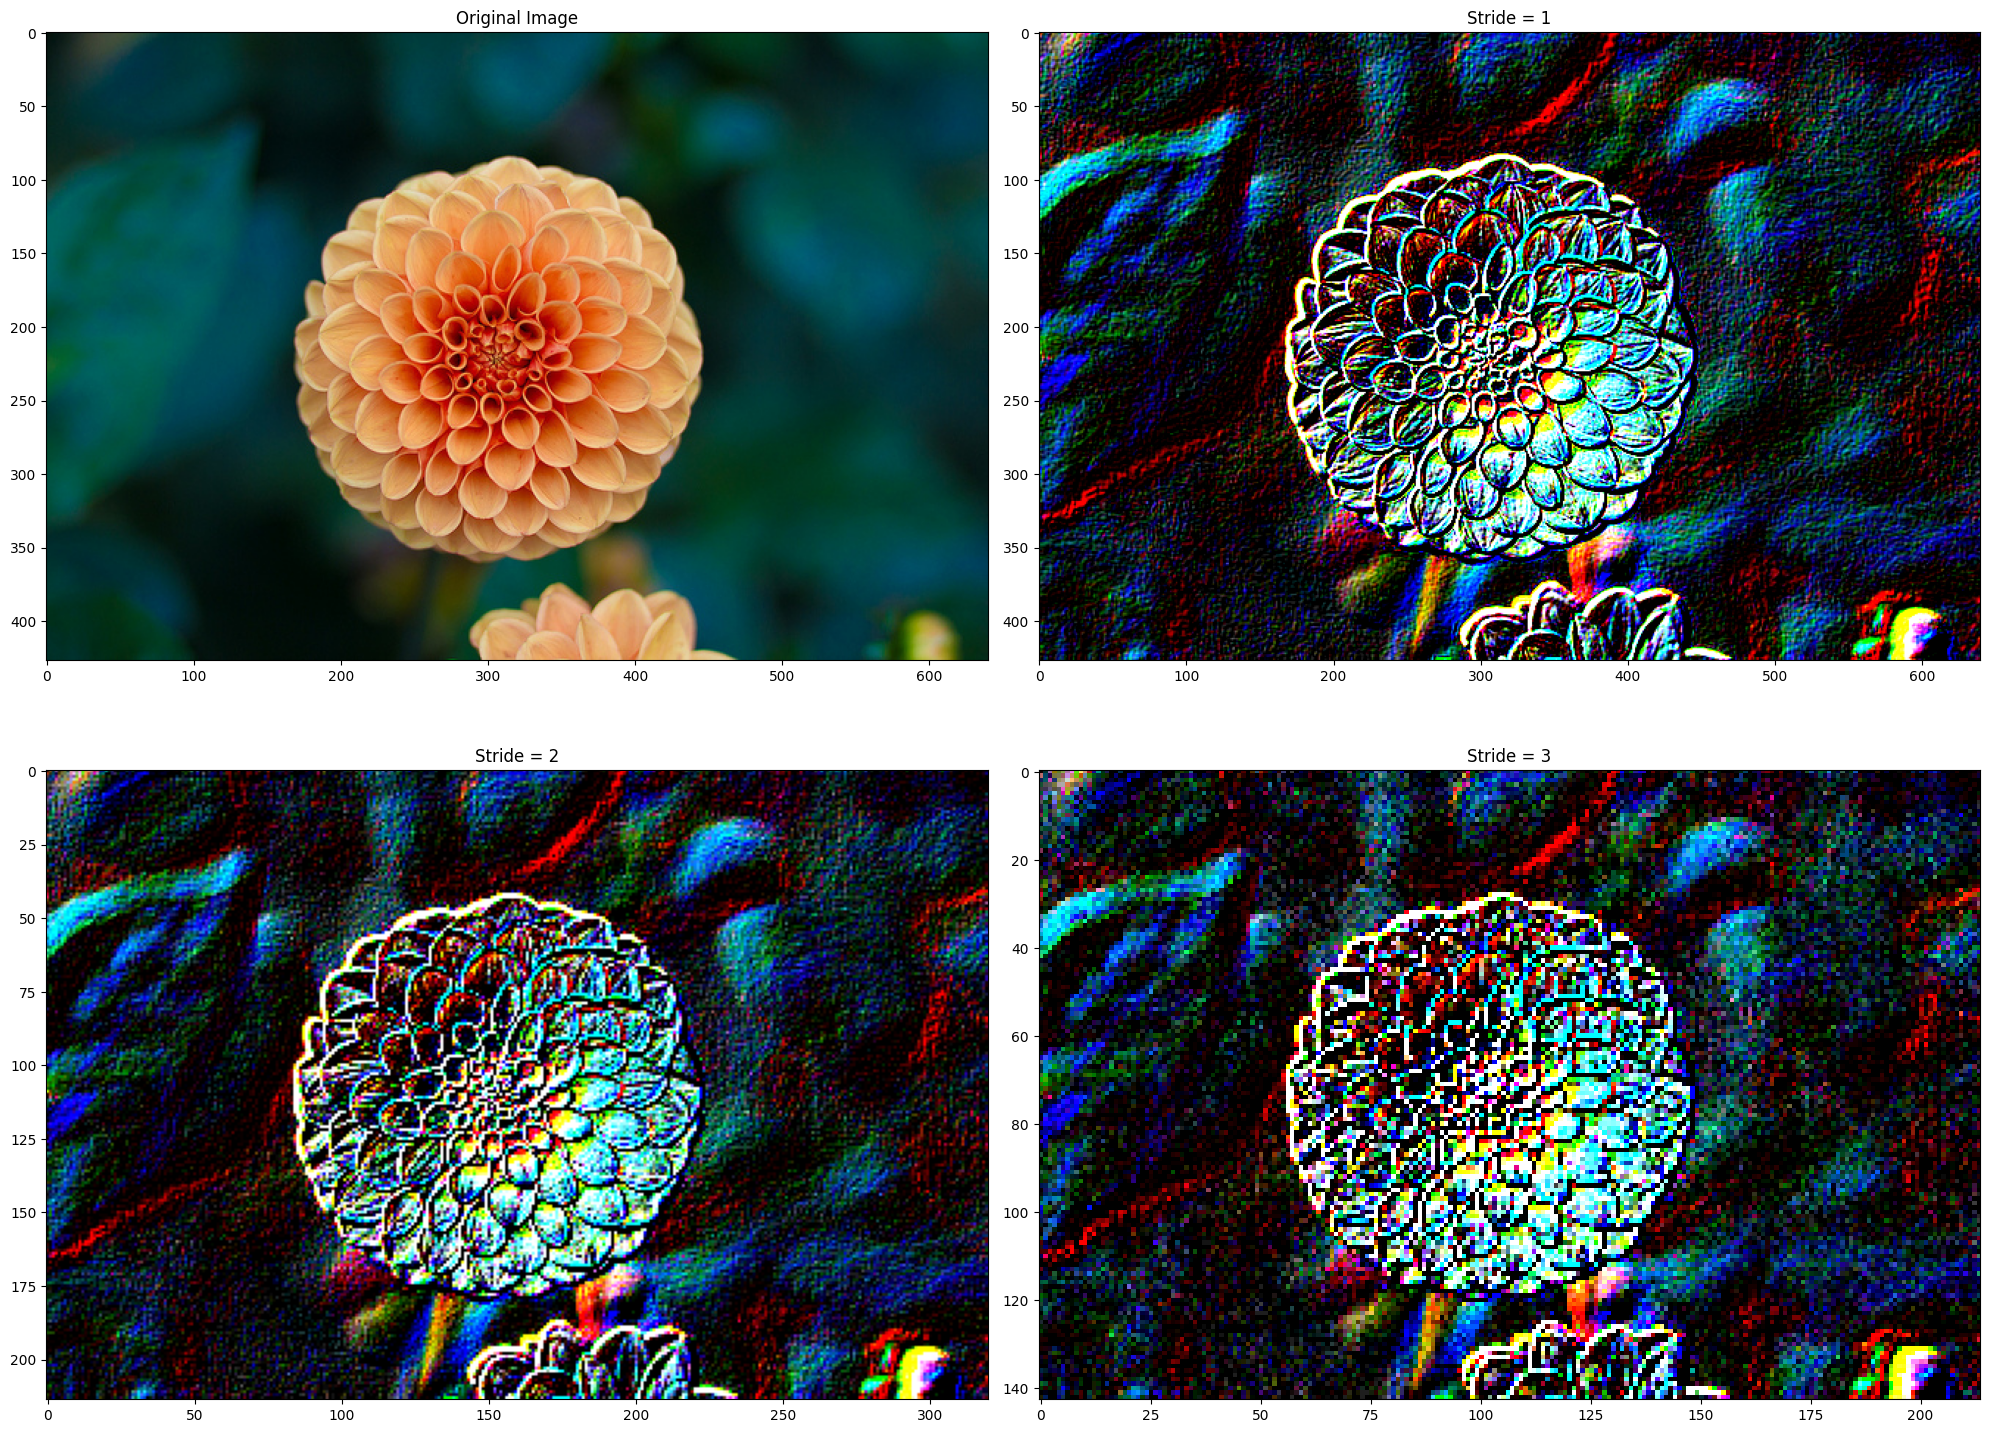

In [13]:

def apply_strided_convolution(image_channel, kernel, stride):
    """
    TODO: Implement strided 2D convolution

    Args:
        image_channel: A padded 2D numpy array (single channel)
        kernel: The 3x3 kernel to apply
        stride: Number of pixels to skip between kernel applications

    Returns:
        The convolved image channel

    Hint:
    1. Calculate the output dimensions based on stride
    2. Modify the pixel position increments using stride
    """
    height, width = image_channel.shape

    #output dimensions
    output_height = ((height - 3) // stride) + 1
    output_width = ((width - 3) // stride) + 1
    output = np.zeros((output_height, output_width))

    #Add your code here!
    # Loop with stride increments
    for i in range(output_height):
        for j in range(output_width):
            # Calculate position in input image using stride
            row = i * stride
            col = j * stride

            # Extract 3x3 region
            region = image_channel[row:row+3, col:col+3]

            # Apply convolution
            output[i, j] = np.sum(region * kernel)

    return output

#the helping hand
def pad_image(image):
    #already assing symmetric padding to the image
    return np.pad(image, ((1,1), (1,1)), mode='symmetric')

def process_image_with_stride(image, kernel, stride):

    #get output dimensions
    h, w, _ = image.shape
    """
    TODO: Define output_height and output_width

    Hint:
    1. Think about the function of stride!
    """
    # Calculate output dimensions considering padding and stride
    # After padding: h+2, w+2
    # After convolution with kernel size 3: (h+2-3) = h-1
    # With stride: ((h-1) // stride) + 1
    output_height = ((h - 1) // stride) + 1
    output_width = ((w - 1) // stride) + 1

    output = np.zeros((output_height, output_width, 3))


    for channel in range(3):
        padded_channel = pad_image(image[:,:,channel])
        output[:,:,channel] = apply_strided_convolution(padded_channel, kernel, stride) / 255.0

    return output

#Test your code people
if __name__ == "__main__":

    horizontal_kernel = np.array([[-10, -10, -10],
                                [0, 0, 0],
                                [10, 10, 10]])

    vertical_kernel = np.array([[-10, 0, 10],
                              [-10, 0, 10],
                              [-10, 0, 10]])

    strides = [1, 2, 3]
    plt.figure(figsize=(20, 15))

    plt.subplot(2, 2, 1)
    plt.imshow(one_image)
    plt.title('Original Image')

    #show results with different strides
    for idx, stride in enumerate(strides):
        filtered_h = process_image_with_stride(one_image, horizontal_kernel, stride)
        filtered_v = process_image_with_stride(one_image, vertical_kernel, stride)
        result = filtered_h + filtered_v

        plt.subplot(2, 2, idx + 2)
        plt.imshow(result)
        plt.title(f'Stride = {stride}')

    plt.tight_layout()
    plt.show()

### Feature Extraction: Let's try it!

Let's download some images!

In [14]:
output_dir = "downloaded_images"
os.makedirs(output_dir, exist_ok=True)

image_urls = [
    "https://www.cdc.gov/healthy-pets/media/images/2024/04/GettyImages-598175960-cute-dog-headshot.jpg",
    "https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg",
    "https://www.dogsforgood.org/wp-content/uploads/2020/06/Dogs-For-Good-October-22-2019-308.jpg",
    "https://www.thesprucepets.com/thmb/b6ck4PC5poXK75uwtOCUF8Z5UG0=/3008x0/filters:no_upscale():strip_icc()/GettyImages-165355962-7529444d03544186ba8ff1b635692407.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Cat_August_2010-4.jpg/1200px-Cat_August_2010-4.jpg"
]

#download and save images
for i, url in enumerate(image_urls, start=1):
    try:
        response = requests.get(url)
        response.raise_for_status()  #Raise an error for bad responses
        file_path = os.path.join(output_dir, f"image_{i}.jpg")
        with open(file_path, "wb") as file:
            file.write(response.content)
        print(f"Downloaded: {file_path}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {url}: {e}")

Downloaded: downloaded_images/image_1.jpg
Downloaded: downloaded_images/image_2.jpg
Failed to download https://www.dogsforgood.org/wp-content/uploads/2020/06/Dogs-For-Good-October-22-2019-308.jpg: 404 Client Error: Not Found for url: https://www.dogsforgood.org/wp-content/uploads/2020/06/Dogs-For-Good-October-22-2019-308.jpg
Failed to download https://www.thesprucepets.com/thmb/b6ck4PC5poXK75uwtOCUF8Z5UG0=/3008x0/filters:no_upscale():strip_icc()/GettyImages-165355962-7529444d03544186ba8ff1b635692407.jpg: 460 Client Error:  for url: https://www.thesprucepets.com/thmb/b6ck4PC5poXK75uwtOCUF8Z5UG0=/3008x0/filters:no_upscale():strip_icc()/GettyImages-165355962-7529444d03544186ba8ff1b635692407.jpg
Failed to download https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Cat_August_2010-4.jpg/1200px-Cat_August_2010-4.jpg: 403 Client Error: Forbidden for url: https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Cat_August_2010-4.jpg/1200px-Cat_August_2010-4.jpg


Now let's get our model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 74.4MB/s]


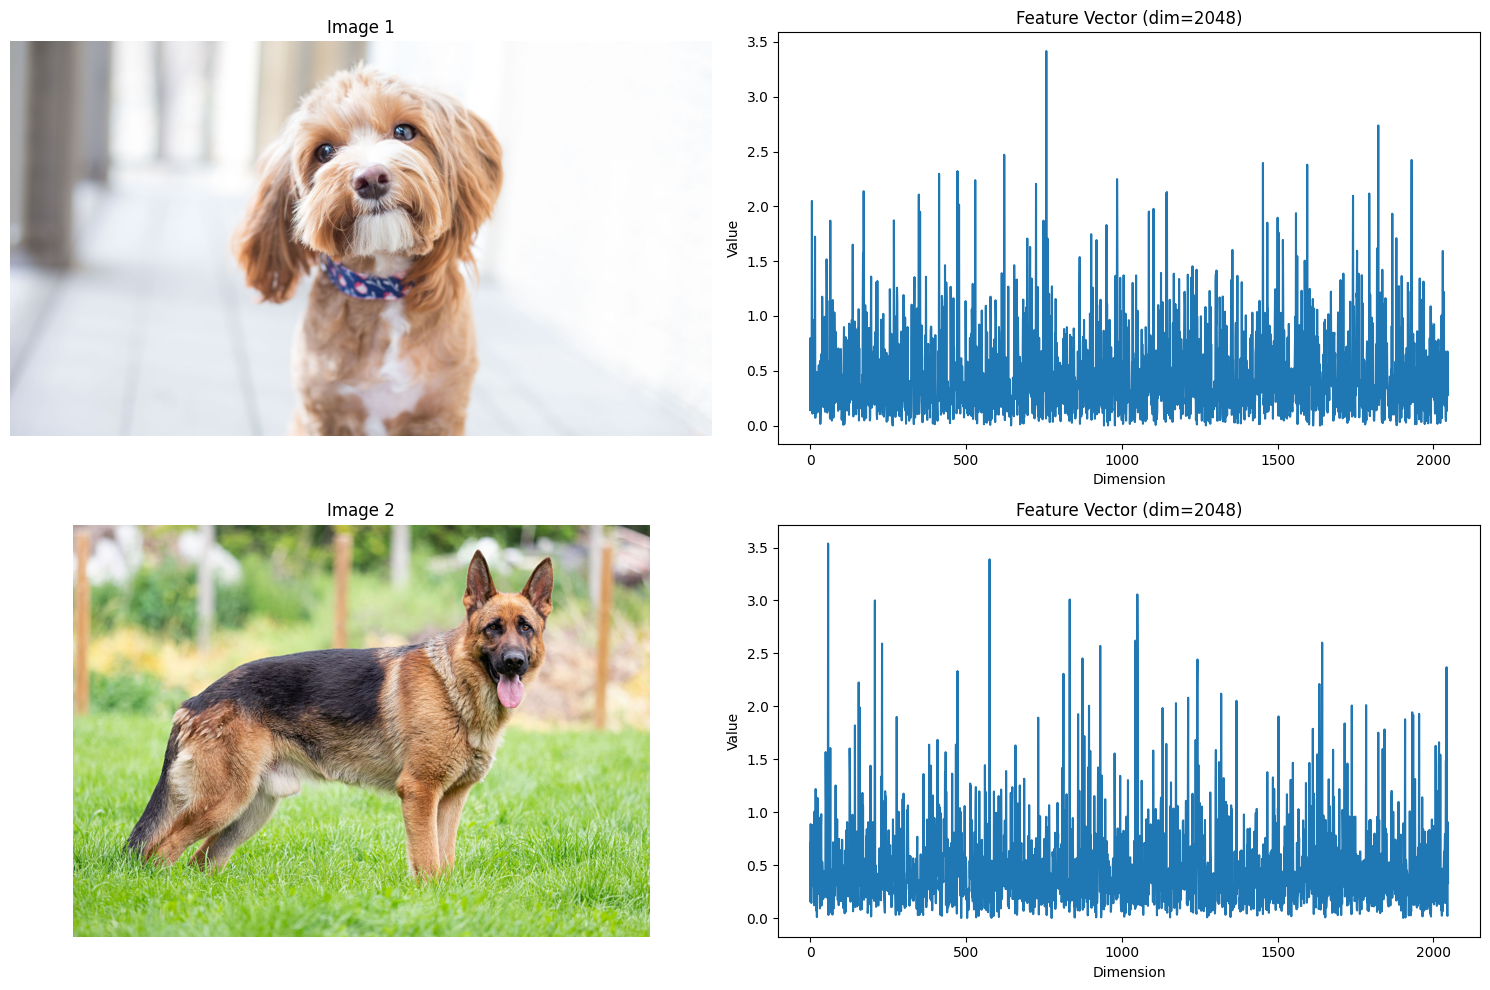


Feature vector dimension: 2048


In [15]:
def get_model():
    #The ResNet came right after alexnet! it added the so called "residual connections" we talked about in class!
    model = models.resnet50(pretrained=True)
    #remove the final fully connected layer - remember this is feature extraction, not classifcation
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    feature_extractor.eval()
    return feature_extractor

#image preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

def extract_features(image_path, model):
    """Extract feature vector from an image using the model"""
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)

    #extract
    with torch.no_grad():
        features = model(image_tensor)

    #flatten
    features = features.squeeze()
    return features, image

def visualize_features_and_images(image_paths, model):
    """Visualize the original images and their feature dimensions"""
    num_images = len(image_paths)
    plt.figure(figsize=(15, 5*num_images))

    for idx, image_path in enumerate(image_paths):
        features, image = extract_features(image_path, model)


        plt.subplot(num_images, 2, 2*idx + 1)
        plt.imshow(image)
        plt.title(f"Image {idx + 1}")
        plt.axis('off')

        plt.subplot(num_images, 2, 2*idx + 2)
        plt.plot(features.cpu().numpy())
        plt.title(f"Feature Vector (dim={features.shape[0]})")
        plt.xlabel("Dimension")
        plt.ylabel("Value")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    image_paths = sorted(Path(output_dir).glob("image_*.jpg"))

    #Step1: load model
    model = get_model()

    #Step2: extract features
    visualize_features_and_images(image_paths, model)

    example_features, _ = extract_features(str(image_paths[0]), model)
    print(f"\nFeature vector dimension: {example_features.shape[0]}")

Now let's find out how similar these images are!

Similarity between image 1 and image 1: 1.000
Similarity between image 1 and image 2: 0.593
Similarity between image 2 and image 1: 0.593
Similarity between image 2 and image 2: 1.000


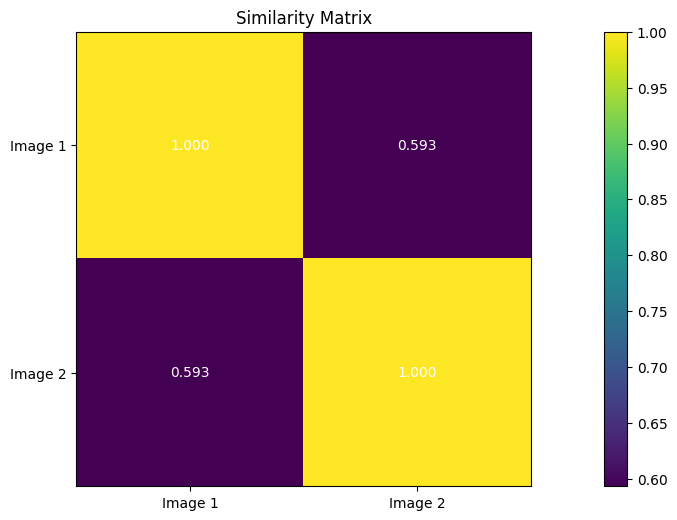

In [16]:
all_similarities = []

feature_vectors = []
for path in image_paths:
    features, _ = extract_features(str(path), model)
    #feature normalization
    features_normalized = features / torch.norm(features)
    feature_vectors.append(features_normalized)

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)

similarity_matrix = torch.zeros((len(feature_vectors), len(feature_vectors)))
for i in range(len(feature_vectors)):
    for j in range(len(feature_vectors)):
        sim = torch.nn.functional.cosine_similarity(
            feature_vectors[i].unsqueeze(0),
            feature_vectors[j].unsqueeze(0)
        )
        similarity_matrix[i, j] = sim
        print(f"Similarity between image {i+1} and image {j+1}: {sim.item():.3f}")

#See the similarity matrix
plt.imshow(similarity_matrix.numpy(), cmap='viridis')
plt.colorbar()
plt.title("Similarity Matrix")
plt.xticks(range(len(image_paths)), [f"Image {i+1}" for i in range(len(image_paths))])
plt.yticks(range(len(image_paths)), [f"Image {i+1}" for i in range(len(image_paths))])

for i in range(len(feature_vectors)):
    for j in range(len(feature_vectors)):
        plt.text(j, i, f'{similarity_matrix[i, j]:.3f}',
                ha='center', va='center', color='white')


plt.tight_layout()
plt.show()


Now that you've seen it work... time for another exercise!

### Exercise 2: Image Search using CNNs

Given a database of 10 images and a query image, find the most similar images. Fill in the TODOs:
1. Build a feature ""database""
2. Compute similarity scores
3. Retrieve the top 3 most similar images


In [ ]:
#Let's get images for you database
output_dir = "database_images"
os.makedirs(output_dir, exist_ok=True)

image_urls = [
    "https://m.media-amazon.com/images/M/MV5BMjRmMTNiMTQtMDg1ZS00MGM1LWE1MGUtYjEzMGFjNWUzOWRkXkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg",
    "https://static.wikia.nocookie.net/thewinx/images/4/4d/Il-destino-di-bloom.png/revision/latest/scale-to-width-down/300?cb=20211010184200",
    "https://resizing.flixster.com/-XZAfHZM39UwaGJIFWKAE8fS0ak=/v3/t/assets/p7894890_b_v10_ad.jpg",
    "https://m.media-amazon.com/images/M/MV5BNzBiODQxZTUtNjc0MC00Yzc1LThmYTMtN2YwYTU3NjgxMmI4XkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg",
    "https://m.media-amazon.com/images/M/MV5BN2M1YzI3OTAtZGY1MS00ZjQ3LTkwMzYtYjI2ODNhZDM2ZGUzXkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg",
    "https://m.media-amazon.com/images/M/MV5BYmM5YWIzMDMtYWZkYS00MGFjLThlNDgtN2ZjNDE0ZjA1OWYwXkEyXkFqcGc@._V1_.jpg",
    "https://m.media-amazon.com/images/M/MV5BNWMyNWY2M2QtNDNjNS00YzY3LWJkMWYtMzdhNmE4OGRhZTBmXkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg",
    "https://resizing.flixster.com/pEBczBamx-gHmTasBaajPymDTN0=/ems.cHJkLWVtcy1hc3NldHMvdHZzZXJpZXMvNjdhNjc3MDMtMThlNS00MTdmLWI5MGYtNjFkMjViZjJlZmFkLmpwZw==",
    "https://m.media-amazon.com/images/M/MV5BMzU5ZGYzNmQtMTdhYy00OGRiLTg0NmQtYjVjNzliZTg1ZGE4XkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg",
    "https://m.media-amazon.com/images/M/MV5BMmIwNjQ5MzEtNTg4Zi00NWMyLThkZDktZDg0MGU4MmYzMjlhXkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg"

]

#download and save images
for i, url in enumerate(image_urls, start=1):
    try:
        response = requests.get(url)
        response.raise_for_status()  #Raise an error for bad responses
        file_path = os.path.join(output_dir, f"image_{i}.jpg")
        with open(file_path, "wb") as file:
            file.write(response.content)
        print(f"Downloaded: {file_path}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {url}: {e}")

Here's your query image

In [ ]:
output_dir = 'query_images'
os.makedirs(output_dir, exist_ok=True)
query_url = "https://br.web.img2.acsta.net/pictures/20/12/07/16/35/0566338.jpg"

try:
    response = requests.get(url)
    response.raise_for_status()  #Raise an error for bad responses
    file_path = os.path.join(output_dir, f"image_{i}.jpg")
    with open(file_path, "wb") as file:
        file.write(response.content)
    print(f"Downloaded: {file_path}")
except requests.exceptions.RequestException as e:
    print(f"Failed to download {url}: {e}")

In [ ]:
def get_feature_extractor():
    model = models.resnet50(pretrained=True)
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    feature_extractor.eval()
    return feature_extractor

def build_feature_database(image_paths, model):
    """
    TODO: Extract features from all database images

    Hint: Use the extract_features function from earlier
    """
    pass

def compute_similarities(query_features, database_features):
    """
    TODO: Compute similarity scores between query and database images

    Hint: Use cosine similarity
    """
    pass

def retrieve_similar_images(query_path, database_paths, model, k=3):
    """
    TODO: Find k most similar images to query image

    Hint: It needs to return a list of tuples for the top k matches
    """
    pass

#Test your code
if __name__ == "__main__":
    #Step1: load the model
    model = get_feature_extractor()

    database_paths = [f"database/image_{i}.jpg" for i in range(10)] #change this to match your path!
    query_path = "query/query_image.jpg" #change this to match your path!

    #Steo2: retrieve similar images
    similar_images = retrieve_similar_images(query_path, database_paths, model)


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(Image.open(query_path))
    plt.title("Query Image")
    plt.axis('off')

    for i, (score, path) in enumerate(similar_images, 2):
        plt.subplot(1, 4, i)
        plt.imshow(Image.open(path))
        plt.title(f"Match {i-1}\nScore: {score:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()